In [32]:
import os
from collections import namedtuple  # Tuplas con nombres (más fácil para acceder a los datos)

import numpy as np  # Cálculo matricial y vectorial
import matplotlib.pyplot as plt  # Graficación
import pandas as pd  # Manejo de hojas de cálculo
import zipfile  # Manejo de archivos ZIP
import scipy.io.wavfile  # Lectura/Escritura de archivos WAV
import scipy.signal  # Procesamiento de señales
from sklearn import set_config  # Parámetros para mostrar los pipelines de sklearn
set_config(display='diagram')
from os.path import join

In [33]:
from utils import  WaveDataset
from utils import WaveDatasetFull
from utils import extract_features

In [34]:
path = r'C:\Users\alfon\Desktop\Projects (On Going)\02. Posgrado CEIA\08. Bimestre VIII\Inteligencia Artificial Embebida\data'
datadir = join(path,'audios')
filedir = join(path, 'train_labels.csv')

In [35]:
train_dataset = WaveDataset(datadir, filedir)

In [36]:
dataset = WaveDatasetFull(datadir, filedir)

[-0.01818903 -0.01812799 -0.01803644 ... -0.00930815 -0.00952177
 -0.0105594 ] 0


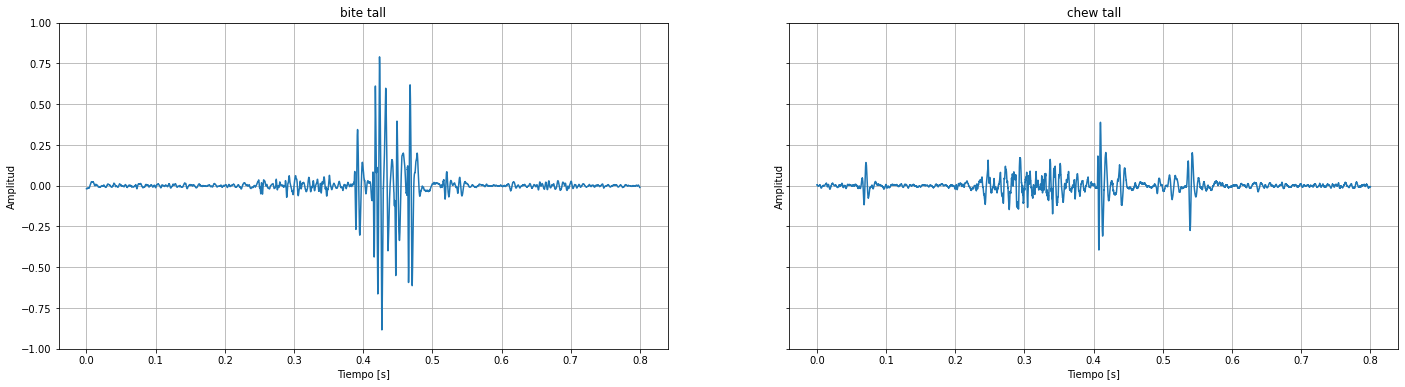

In [37]:
t = np.arange(0,len(train_dataset[24].data)/train_dataset[24].sample_freq, 1/train_dataset[24].sample_freq)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,6), sharey=True)
axes[0].set_ylim((-1, 1))
axes[0].set_ylim((-1, 1))

axes[0].set_title("bite tall")
axes[0].plot(t, train_dataset[24].data)
axes[0].set_xlabel('Tiempo [s]')
axes[0].set_ylabel('Amplitud')
axes[0].grid(True)
print(train_dataset[24].data, train_dataset[24].label)

axes[1].set_title("chew tall")
axes[1].plot(t, train_dataset[2].data)
axes[1].set_xlabel('Tiempo [s]')
axes[1].set_ylabel('Amplitud')
axes[1].grid(True)

[-0.02691733 -0.0270394  -0.02645955 ... -0.00875881 -0.00854518
 -0.00845363] 0


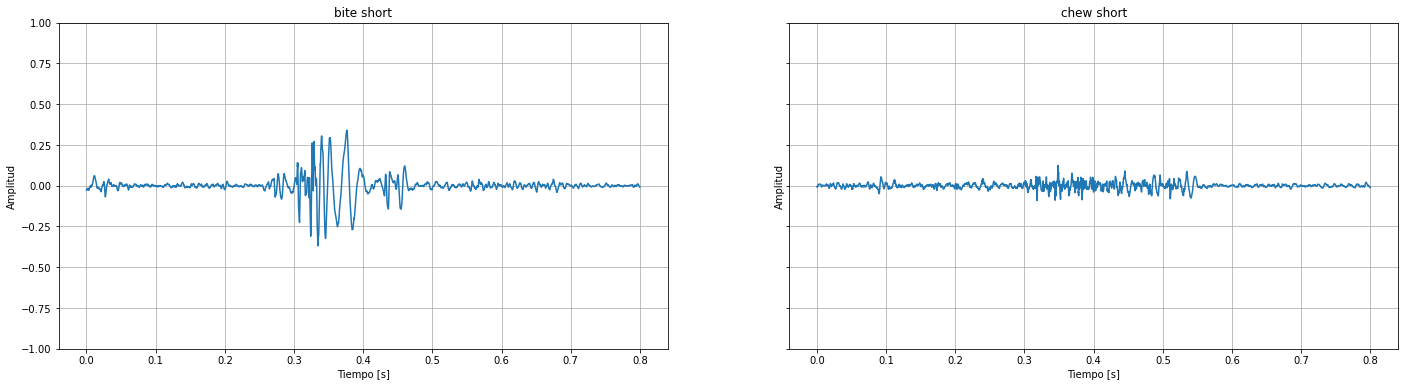

In [38]:
t = np.arange(0,len(train_dataset[24].data)/train_dataset[24].sample_freq, 1/train_dataset[24].sample_freq)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,6), sharey=True)
axes[0].set_ylim((-1, 1))
axes[0].set_ylim((-1, 1))

axes[0].set_title("bite short")
axes[0].plot(t, train_dataset[444].data)
axes[0].set_xlabel('Tiempo [s]')
axes[0].set_ylabel('Amplitud')
axes[0].grid(True)
print(train_dataset[444].data, train_dataset[444].label)

axes[1].set_title("chew short")
axes[1].plot(t, train_dataset[449].data)
axes[1].set_xlabel('Tiempo [s]')
axes[1].set_ylabel('Amplitud')
axes[1].grid(True)

In [39]:
i_chewshort = np.where((dataset.height == 'short') & (dataset.labels == 0 ))
i_chewtall = np.where((dataset.height == 'tall') & (dataset.labels == 0 ))

ratio = np.count_nonzero(i_chewshort)/np.count_nonzero(i_chewtall)
ratio

1.0731707317073171

In [40]:
X_train = np.vstack([extract_features(wavdata.data, wavdata.sample_freq) for wavdata in train_dataset])
y_train = np.array([wavdata.label for wavdata in train_dataset])

In [41]:
from sklearn.decomposition import PCA
sample = []
for i in range(0, len(train_dataset)):
    sample.append(train_dataset[i].data)



In [42]:
sample_arr = np.array(sample)

In [ ]:
pca = PCA(n_components= 1000)
sample_pca = pca.fit(np.transpose(sample_arr))

In [81]:
np.sum(sample_pca.explained_variance_ratio_)

0.9994937430822598

In [82]:
sample_pca_val = sample_pca.components_

In [86]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components= 5, max_iter=5000)
sample_ica = ica.fit(sample_pca_val)

In [87]:
sample_ica.components_.shape

(5, 1532)

In [89]:
X_train = np.transpose(sample_ica.components_)
y_train = np.array([wavdata.label for wavdata in train_dataset])

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

In [45]:
# Genera una nueva particion desde el conjunto de train
X_train_opt, X_optim, y_train_opt, y_optim = train_test_split(X_train,
                                                              y_train,
                                                              test_size=0.33,
                                                              random_state=42)

    
# Se define el modelo
model = make_pipeline(
                          StandardScaler(),
                          DecisionTreeClassifier(max_depth=5, min_samples_leaf=1),
                          #MLPClassifier(random_state=42, max_iter=2000, early_stopping=False, n_iter_no_change=100)
                          #RandomForestClassifier(n_estimators=1, random_state=42)
                     )

# Se entrena el modelo
model.fit(X_train_opt, y_train_opt)

# Se prueba con la partición de optimización
y_pred_optim = model.predict(X_optim)

sc = balanced_accuracy_score(y_optim, y_pred_optim)
print(f"{sc:.3f} balanced accuracy")

0.719 balanced accuracy


In [46]:
# Reporte de clasificación
report = classification_report(y_optim,
                               y_pred_optim, 
                               target_names=["bite", "chew", "chewbite"])

print(report)

              precision    recall  f1-score   support

        bite       0.61      0.47      0.53        98
        chew       0.81      0.90      0.85       255
    chewbite       0.82      0.78      0.80       153

    accuracy                           0.78       506
   macro avg       0.75      0.72      0.73       506
weighted avg       0.77      0.78      0.78       506



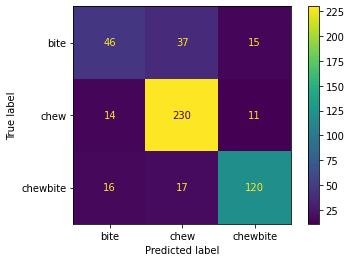

In [47]:
# matriz de confusión
cm = confusion_matrix(y_optim, y_pred_optim)
ConfusionMatrixDisplay(cm,
                       display_labels=["bite", "chew", "chewbite"]).plot()
plt.grid(False)
plt.show()

In [48]:
from sklearn.model_selection import cross_validate, StratifiedKFold

scores_to_use = ("balanced_accuracy", )  # "accuracy" favoreceria a la clase mas representada

# Validación cruzada con folds y scores definidos
cv_scores = cross_validate(model,
                           X_train,
                           y_train, 
                           cv=StratifiedKFold(3),
                           scoring=scores_to_use,
                           verbose=0)

for sc in scores_to_use:
    
    print(f'Medida: {sc}',
          cv_scores[f'test_{sc}'],
          np.mean(cv_scores[f"test_{sc}"]),
          sep="\n")

Medida: balanced_accuracy
[0.67312589 0.60640807 0.70211527]
0.6605497429538351


In [50]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# Genera una nueva particion desde el conjunto de train
X_train_in, X_optim, y_train_in, y_optim = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.33,
                                                            random_state=42)


In [53]:
model = imb_make_pipeline(
                              RandomUnderSampler(random_state=42),
                              StandardScaler(),
                              RandomForestClassifier(n_estimators=100, random_state=42)
                             )


# Se entrena el modelo
model.fit(X_train_in, y_train_in)

# Se prueba con la partición de optimización
y_pred_optim = model.predict(X_optim)

sc = balanced_accuracy_score(y_optim, y_pred_optim)
print(f"{sc:.3f} balanced accuracy")

0.738 balanced accuracy
